# Script to find out the important descriptors involved in the feature selection

In [2]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')

In [3]:
def getFeatures(df ,model,factor_loadings_path=None,isPC=True,target='Neuroticism',n_components=3):
    '''
    Find the 30 most important predictors
    in case of PC its find out the 30 most important predictors from the best PCs selected
    In case of original features 30 most important predictors are taken into consideration
    '''
    features_list_by_models=[]
    df = df[df['Target']==target]
    temp = df[df['Algorithm']==model]
    if 'Features' in temp:
        x3= temp['Features']
        if(model == 'MARS' and isPC==True):
            x3= temp['Features'].values[0].replace('PC','').split(',')
            for i in range(0, len(x3)):
                x3[i] =str(int(x3[i])-1)
        elif(model != 'MARS' and isPC==True):
            x3 = x3.values[0].replace('  ',' ').replace('[','').replace(']','').replace('\n','').replace('\r','').strip().split(' ')
        elif(model=='MARS' and isPC==False):
            x3 = x3.values[0].split(',')
        else:
            x3= x3.values[0].replace('\'', '').replace('[','').replace(']','').replace('\n','').replace('\r','').split(' ')
    else:
        x3=np.arange(0,n_components)
        x3 = [str(x) for x in x3]
        
    x3_features=[]
    temp=[]
    if(isPC==True):
        # find the features of each PC and find the 30 best largest mean
        df_factor_loadings = pd.read_csv(factor_loadings_path,index_col=0)
        features = df_factor_loadings[x3].mean(axis=1).nlargest(30).index.values
        features_list_by_models.append(features)
    else:
        x3=x3[:30] # select top 30 predictors
        features_list_by_models.append(x3)
    return features_list_by_models[0]

In [6]:
def getDescriptors(df,dict_factor_loadings=None,isPC=True,target='Neuroticism'):
    descriptors_list_by_models=[]
    
    models = ['SVM','Random Forest','MARS','Linear regression', 'Elastic Net','Lasso Regression']
    for model in models:
        features_list_by_models=getFeatures(df,model,dict_factor_loadings,isPC,target=target)
        descriptors = ','.join(features_list_by_models).replace('_mean','').replace('_median','') \
                .replace('_kurt','').replace('_skew','').replace('_quantile','').replace('_std','') \
                .replace('_min','').replace('_count','').replace('_max','').replace('_mad','').split(',')
        descriptors_list_by_models.append(descriptors)
    
    data = pd.concat([pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[0])),orient='index',columns=['SVM']),
              pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[1])),orient='index',columns=['RF']),
              pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[2])),orient='index',columns=['MARS']),
            pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[3])),orient='index',columns=['LR']),
            pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[4])),orient='index',columns=['ElasticNet']),
            pd.DataFrame.from_dict(collections.Counter(np.array(descriptors_list_by_models[5])),orient='index',columns=['Lasso'])
                     ],axis=1)
    data = data.fillna(0)
    data['Descriptors']=data.index
    return data

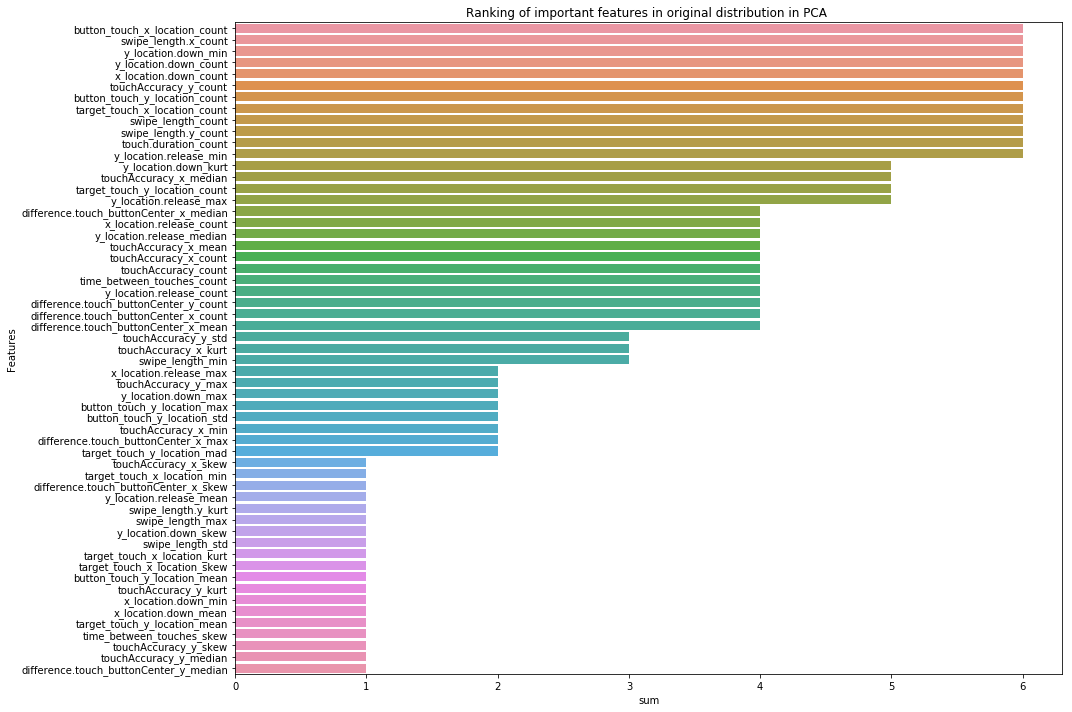

In [7]:
factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis.csv'
df = pd.read_csv('feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
features_list_by_models=[]
target ='Neuroticism'
models = ['SVM','Random Forest','MARS','Linear regression', 'Elastic Net','Lasso Regression']
# getFeatures(df ,'SVM',factor_loadings_path,isPC=True,target=target)
for model in models:
    features_list_by_models.append(getFeatures(df ,model,factor_loadings_path,isPC=True))
data = pd.concat([pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[0])),orient='index',columns=['SVM']),
              pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[1])),orient='index',columns=['RF']),
              pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[2])),orient='index',columns=['MARS']),
            pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[3])),orient='index',columns=['LR']),
            pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[4])),orient='index',columns=['ElasticNet']),
            pd.DataFrame.from_dict(collections.Counter(np.array(features_list_by_models[5])),orient='index',columns=['Lasso'])
                     ],axis=1)

data = data.fillna(0)
data['Features']=data.index
plt.figure(figsize=(15,10))
data['sum']=data.sum(axis=1)
sns.barplot(x='sum',y='Features',data=data.sort_values(by='sum', ascending=False))
plt.title('Ranking of important features in original distribution in PCA ')
plt.tight_layout()

# d

# df[df['Algorithm']=='SVM']['Features']

In [8]:
def plot(data,title,groupbyCol='Descriptors'):
    
    means = data.groupby(by=groupbyCol).mean().fillna(0).reset_index()
    
    
    sd  = data.groupby(by=groupbyCol).std().fillna(0).reset_index()
    

    
    labels = means[groupbyCol]
    
    svm_means =means['SVM']
#     print(svm_means)
    svm_sd = sd['SVM']#/np.sqrt(6)
#     print(svm_means)
#     print(svm_sd)
    
    ind = np.arange(len(means))  # the x locations for the groups
    width = 0.15      # the width of the bars
    
    colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    fig, ax = plt.subplots(figsize=(20,10))
    rects1 = ax.bar(ind, svm_means, width, color=colors[0]
                    ,yerr=svm_sd,capsize=5
                   )


    rf_means = means['RF']
    rf_sd= sd['RF']#/np.sqrt(6)
    rects2 = ax.bar(ind + width, rf_means, width, color=colors[1], 
                    yerr=rf_sd,capsize=5
                   )

    mars_means = means['MARS']
    mars_sd=sd['MARS']#/np.sqrt(6)
    rects3 = ax.bar(ind + 2*width, mars_means, width, color=colors[2],
                    yerr=mars_sd,capsize=5
                   )

    lr_means = means['LR']
    lr_sd=sd['LR']#/np.sqrt(6)
    rects4 = ax.bar(ind - width, lr_means, width, color=colors[3],
                    yerr=lr_sd,capsize=5
                   )
    
    enet_means = means['ElasticNet']
    enet_sd=sd['ElasticNet']#/np.sqrt(6)
    rects5 = ax.bar(ind - 2*width, enet_means, width, color=colors[4],
                    yerr=enet_sd,capsize=5
                   )
    
    lasso_means = means['Lasso']
    lasso_sd=sd['Lasso']#/np.sqrt(6)
    rects6 = ax.bar(ind - 3*width, lasso_means, width, color=colors[5],
                    yerr=lasso_sd,capsize=5
                   )
    
#     # add some text for labels, title and axes ticks
    ax.set_ylabel('Mean')
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    ax.set_xlabel(groupbyCol)
#     ax.tick_params(direction='out', length=6, width=2, colors='r',
#                    grid_color='r', grid_alpha=0.5)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
                 rotation_mode="anchor")
    plt.tight_layout()
    ax.legend((rects1[0], rects2[0],rects3[0], rects4[0],rects5[0],rects6[0]), ('SVM', 
                                                                                'Random Forest','MARS','Linear regression','Elastic Net',
                                                                                'Lasso'))
    plt.show()


In [9]:
def generate_heatmap_fs(descriptors, descriptors_count,title,axes=None):
#     fig,axes = plt.subplots(figsize=(6,8))
    models=['First Best Model','Second Best Model']
    im = axes.imshow(descriptors_count,cmap="RdBu_r",vmin=1,vmax=5)
#     print(descriptors_count)
    axes.set_xticks(np.arange(len(models)))
    axes.set_yticks(np.arange(len(descriptors)))
    axes.set_xticklabels(models)
    axes.set_yticklabels(descriptors)
    fig.colorbar(im , ax=axes)
    plt.setp(axes.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(len(descriptors)):
        for j in range(len(models)):
            text = axes.text(j, i, descriptors_count[i, j],
                           ha="center", va="center", color="black",weight='bold')
    axes.set_title(title,weight='bold')
    return axes

def display_fs_count(descriptors,descriptors_count,models,axis_title,label_color,axes=None):
    df=pd.DataFrame()
    for i in range(len(descriptors_count)):
        data={'count':descriptors_count[i],'descriptors':descriptors,'model':models[i]}
        df=df.append(pd.DataFrame(data=data),ignore_index=True)

    # plot bar graph
    sns.barplot(x='count',y='descriptors',hue='model',data=df, palette=label_color, ax=axes)
    axes.set_title(axis_title, weight='bold')
    return axes

Study1+Study2
---

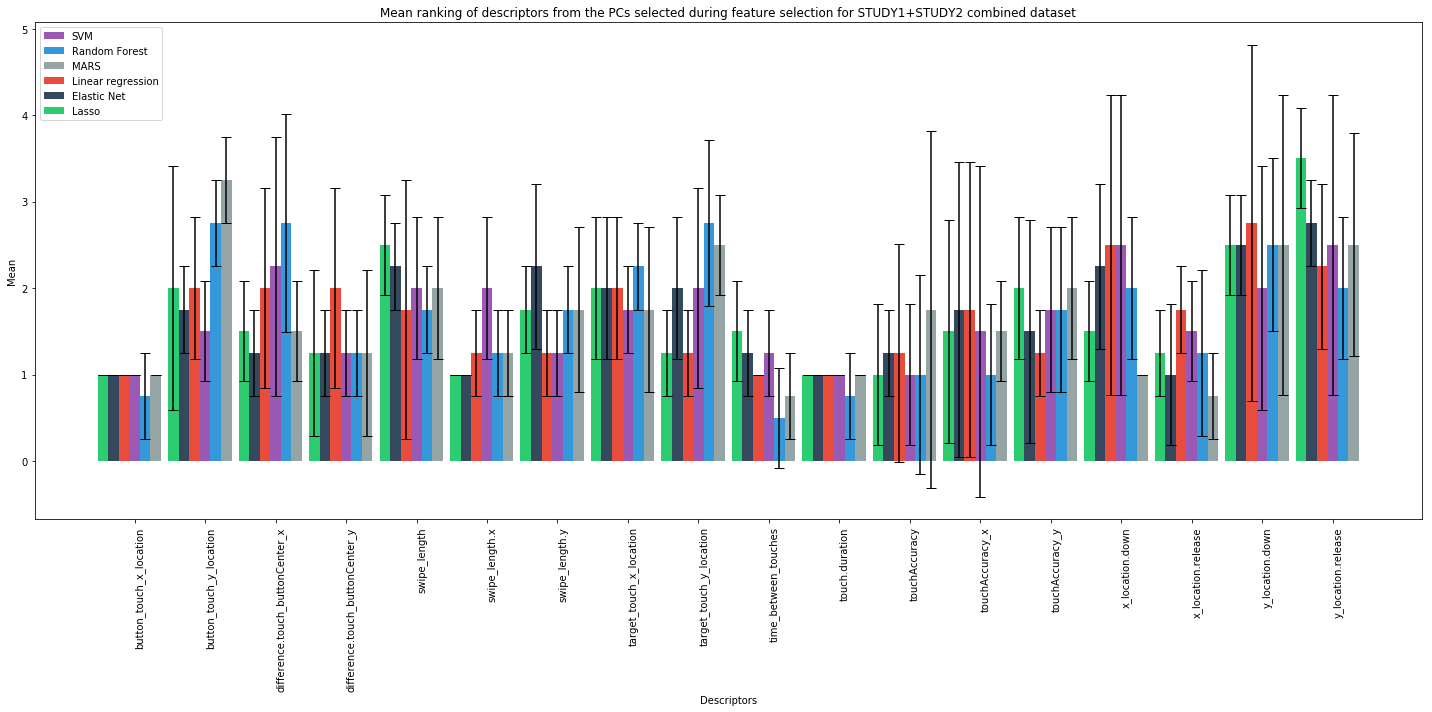

In [10]:
df = pd.read_csv('feature_selection_mahalanobis_alltargets.csv')
descriptors_details_by_models_1 = getDescriptors(df,isPC=False)
descriptors_details_by_models_1['Method']='GA_original'

df = pd.read_csv('feature_selection_mahalanobis_transformed_alltargets.csv')
descriptors_details_by_models_2 = getDescriptors(df,isPC=False)
descriptors_details_by_models_2['Method']='GA_transformed'

factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis.csv'
df = pd.read_csv('feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True)
descriptors_details_by_models_3['Method']='GA_original_0.80PC'
# 
factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis_transformedDistributions.csv'
df = pd.read_csv('feature_selection_mahalanobis_transformed_alltargets_PCA_0.80PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True)
descriptors_details_by_models_4['Method']='GA_transformed_0.80PC'

factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis.csv'
df = pd.read_csv('feature_selection_mahalanobis_alltargets_PCA_0.95PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_5 = getDescriptors(df,factor_loadings_path,isPC=True)
descriptors_details_by_models_5['Method']='GA_original_0.95PC'

factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis_transformedDistributions.csv'
df = pd.read_csv('feature_selection_mahalanobis_transformed_alltargets_PCA_0.95PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_6 = getDescriptors(df,factor_loadings_path,isPC=True)
descriptors_details_by_models_6['Method']='GA_transformed_0.95PC'

plot_df = pd.concat([#descriptors_details_by_models_1,
           #descriptors_details_by_models_2,
          descriptors_details_by_models_3,
          descriptors_details_by_models_4,
             descriptors_details_by_models_5,
               descriptors_details_by_models_6
])#.groupby(by='Descriptors').mean().fillna(0).reset_index()

title='Mean ranking of descriptors from the PCs selected during feature selection for STUDY1+STUDY2 combined dataset'
plot(plot_df,title)

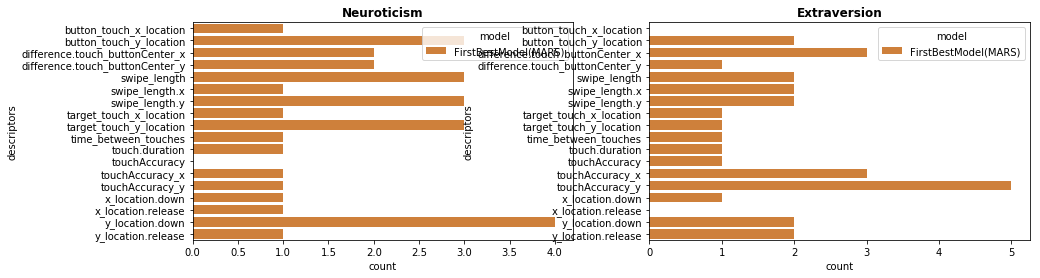

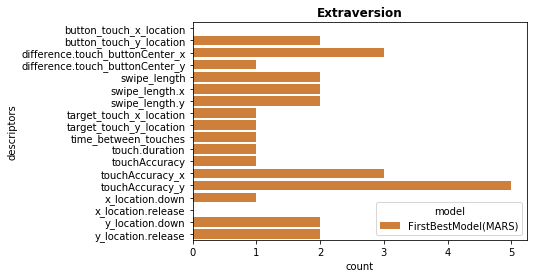

In [28]:
'''
TODO: plot the features only for 2 best models seperately
and then check in combination
'''

## for Neuroticism
target='Neuroticism'
factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis.csv'
df = pd.read_csv('feature_selection_mahalanobis_alltargets_PCA_0.95PC.csv')
descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_3['Method']='GA_original_0.95PC'


df = pd.read_csv('feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_4['Method']='GA_original_0.80PC'


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_3.sort_values(by='MARS', ascending=False),ax=ax1)
# plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax1.set_ylabel('Count')
# ax1.set_yticks(np.arange(0,6))
# ax1.set_title('MARS')

# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_4.sort_values(by='MARS', ascending=False),ax=ax2)
# plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax2.set_yticks(np.arange(0,6))
# ax2.set_ylabel('Count')
# ax2.set_title('MARS')

# fig.suptitle('Ranking of important features for two best models for PQ',y=1.03,weight='bold')
# plt.tight_layout()
# plt.show()

# mars = descriptors_details_by_models_3.sort_values(by='MARS', ascending=False)
# best1 = mars[mars['MARS']>1]['Descriptors'].values
# svm = descriptors_details_by_models_4.sort_values(by='MARS', ascending=False)
# best2 = svm[svm['MARS']>1]['Descriptors'].values
# print("Common features selected for Neuroticism are:\n",set(best1)&(set(best2)))

fs_scores=[]
fs_scores.append(list(descriptors_details_by_models_3['MARS'].values))
# fs_scores.append(list(descriptors_details_by_models_4['MARS'].values))
descriptors=descriptors_details_by_models_3.index
# generate_heatmap_fs(descriptors,np.array(fs_scores).T,'Neuroticism',ax1)
display_fs_count(descriptors,fs_scores,['FirstBestModel(MARS)'],'Neuroticism',["#E67E22"],ax1)




# for Extraversion
target='Extraversion'
factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis.csv'
df = pd.read_csv('feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_3['Method']='GA_original_0.80PC'

factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis_transformedDistributions.csv'
df = pd.read_csv('feature_selection_mahalanobis_transformed_alltargets_PCA_0.80PC.csv')
descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_4['Method']='GA_Transformed_0.80PC'

# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_3.sort_values(by='MARS', ascending=False),ax=ax1)
# plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax1.set_ylabel('Count')
# ax1.set_yticks(np.arange(0,6))
# ax1.set_title('MARS')

# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_4.sort_values(by='MARS', ascending=False),ax=ax2)
# plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax2.set_yticks(np.arange(0,6))
# ax2.set_ylabel('Count')
# ax2.set_title('MARS')

# fig.suptitle('Ranking of important features for two best models for Extraversion',y=1.03,weight='bold')
# plt.tight_layout()
# plt.show()

# mars = descriptors_details_by_models_3.sort_values(by='MARS', ascending=False)
# best1 = mars[mars['MARS']>1]['Descriptors'].values
# svm = descriptors_details_by_models_4.sort_values(by='MARS', ascending=False)
# best2 = svm[svm['MARS']>1]['Descriptors'].values
# print("Common features selected for Extraversion are:\n",set(best1)&(set(best2)))
fs_scores=[]
fs_scores.append(list(descriptors_details_by_models_3['MARS'].values))
# fs_scores.append(list(descriptors_details_by_models_4['RF'].values))
descriptors=descriptors_details_by_models_3.index
# generate_heatmap_fs(descriptors,np.array(fs_scores).T,'Extraversion',ax2)
display_fs_count(descriptors,fs_scores,['FirstBestModel(MARS)'],'Extraversion',["#E67E22"],ax2)
fig,ax=plt.subplots(figsize=(6,4))
display_fs_count(descriptors,fs_scores,['FirstBestModel(MARS)'],'Extraversion',["#E67E22"],ax)
plt.show()

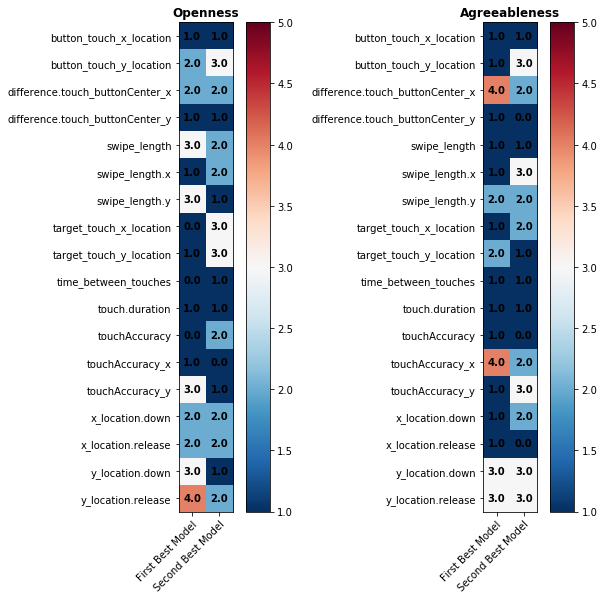

In [20]:
'''
TODO: plot the features only for 2 best models seperately
and then check in combination
'''

## for Openness
target='Openness'
factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis.csv'
df = pd.read_csv('feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_3['Method']='GA_original_0.80PC'
# 
factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis_transformedDistributions.csv'
df = pd.read_csv('feature_selection_mahalanobis_transformed_alltargets_PCA_0.80PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_4['Method']='GA_transformed_0.80PC'


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,9))
# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_3.sort_values(by='MARS', ascending=False),ax=ax1)
# plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax1.set_ylabel('Count')
# ax1.set_yticks(np.arange(0,6))
# ax1.set_title('MARS')

# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_4.sort_values(by='MARS', ascending=False),ax=ax2)
# plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax2.set_yticks(np.arange(0,6))
# ax2.set_ylabel('Count')
# ax2.set_title('MARS')

# fig.suptitle('Ranking of important features for two best models for Openness',y=1.03,weight='bold')
# plt.tight_layout()
# plt.show()

# mars = descriptors_details_by_models_3.sort_values(by='MARS', ascending=False)
# best1 = mars[mars['MARS']>1]['Descriptors'].values
# svm = descriptors_details_by_models_4.sort_values(by='MARS', ascending=False)
# best2 = svm[svm['MARS']>1]['Descriptors'].values
# print("Common features selected for Openness are:\n",set(best1)&(set(best2)))


fs_scores=[]
fs_scores.append(list(descriptors_details_by_models_3['MARS'].values))
fs_scores.append(list(descriptors_details_by_models_4['MARS'].values))
descriptors=descriptors_details_by_models_3.index
generate_heatmap_fs(descriptors,np.array(fs_scores).T,'Openness',ax1)

# for Agreeableness
target='Agreeableness'
factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis.csv'
df = pd.read_csv('feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_3['Method']='GA_original_0.80PC'

df = pd.read_csv('feature_selection_mahalanobis_alltargets_PCA_0.95PC.csv')
descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_4['Method']='GA_original_0.95PC'

# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_3.sort_values(by='MARS', ascending=False),ax=ax1)
# plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax1.set_ylabel('Count')
# ax1.set_yticks(np.arange(0,6))
# ax1.set_title('MARS')

# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_4.sort_values(by='MARS', ascending=False),ax=ax2)
# plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax2.set_yticks(np.arange(0,6))
# ax2.set_ylabel('Count')
# ax2.set_title('MARS')

# fig.suptitle('Ranking of important features for two best models for Agreeableness',y=1.03,weight='bold')
# plt.tight_layout()
# plt.show()

# mars = descriptors_details_by_models_3.sort_values(by='MARS', ascending=False)
# best1 = mars[mars['MARS']>1]['Descriptors'].values
# svm = descriptors_details_by_models_4.sort_values(by='MARS', ascending=False)
# best2 = svm[svm['MARS']>1]['Descriptors'].values
# print("Common features selected for Agreeableness are:\n",set(best1)&(set(best2)))

fs_scores=[]
fs_scores.append(list(descriptors_details_by_models_3['MARS'].values))
fs_scores.append(list(descriptors_details_by_models_4['MARS'].values))
descriptors=descriptors_details_by_models_3.index
generate_heatmap_fs(descriptors,np.array(fs_scores).T,'Agreeableness',ax2)
plt.show()

In [ ]:
# for Conscientiousness
target='Conscientiousness'
factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis.csv'
df = pd.read_csv('feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_3['Method']='GA_original_0.80PC'
# 
factor_loadings_path = 'PCA-Factor-Loadings/PCA_mahalanobis_transformedDistributions.csv'
df = pd.read_csv('feature_selection_mahalanobis_transformed_alltargets_PCA_0.80PC.csv')
# dict_factor_loadings = getFactorLoadings(factor_loadings_path)
descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
descriptors_details_by_models_4['Method']='GA_transformed_0.80PC'

fig, ax1 = plt.subplots(1,1,figsize=(10,9))
# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_3.sort_values(by='MARS', ascending=False),ax=ax1)
# plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax1.set_ylabel('Count')
# ax1.set_yticks(np.arange(0,6))
# ax1.set_title('MARS')

# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_4.sort_values(by='MARS', ascending=False),ax=ax2)
# plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax2.set_yticks(np.arange(0,6))
# ax2.set_ylabel('Count')
# ax2.set_title('MARS')

# fig.suptitle('Ranking of important features for two best models for Conscientiousness',y=1.03,weight='bold')
# plt.tight_layout()
# plt.show()

# mars = descriptors_details_by_models_3.sort_values(by='MARS', ascending=False)
# best1 = mars[mars['MARS']>1]['Descriptors'].values
# svm = descriptors_details_by_models_4.sort_values(by='MARS', ascending=False)
# best2 = svm[svm['MARS']>1]['Descriptors'].values
# print("Common features selected for Conscientiousness are:\n",set(best1)&(set(best2)))
fs_scores=[]
fs_scores.append(list(descriptors_details_by_models_3['MARS'].values))
fs_scores.append(list(descriptors_details_by_models_4['MARS'].values))
descriptors=descriptors_details_by_models_3.index
generate_heatmap_fs(descriptors,np.array(fs_scores).T,'Conscientiousness',ax1)

In [ ]:
# summed= plot_df.groupby(by='Descriptors').mean().fillna(0).reset_index()#.sort_values(by='SVM',ascending=False)[['SVM','Descriptors']]
# plot_by_model(summed, 'Features contributions in the selected PCs by Genetic Algorithm')

In [ ]:
# plot_df_GA = pd.concat([descriptors_details_by_models_1,
#            descriptors_details_by_models_2,])#.groupby(by='Descriptors').mean().fillna(0).reset_index()
# summed= plot_df_GA.groupby(by='Descriptors').sum().fillna(0).reset_index()
# title='Mean ranking of descriptors from their statistical derivatives selected during feature selection for STUDY 1 dataset'
# plot_by_model(summed,'Base Features selected by Genetic Algorithm')
# # plot_df.groupby(by='Descriptors').head()

In [ ]:
# df = pd.read_csv('study2_feature_selection_mahalanobis_alltargets.csv')

# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# descriptors_details_by_models_1 = getDescriptors(df,isPC=False)
# descriptors_details_by_models_1['Method']='GA_original'


# df = pd.read_csv('study2_feature_selection_mahalanobis_transformed_alltargets.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadtings_path)
# descriptors_details_by_models_2 = getDescriptors(df,isPC=False)
# descriptors_details_by_models_2['Method']='GA_transformed'

# # plot_df = pd.concat([descriptors_details_by_models_1,
# #            descriptors_details_by_models_2,])#.groupby(by='Descriptors').mean().fillna(0).reset_index()

# # title='Mean ranking of descriptors from their statistical derivatives selected during feature selection for STUDY 2 dataset'
# # plot(plot_df,title)

# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True)
# descriptors_details_by_models_3['Method']='GA_original_0.80PC'

# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis_transformedDistributions.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_transformed_alltargets_PCA_0.80PC.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True)
# descriptors_details_by_models_4['Method']='GA_transformed_0.80PC'

# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_alltargets_PCA_0.95PC.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# descriptors_details_by_models_5 = getDescriptors(df,factor_loadings_path,isPC=True)
# descriptors_details_by_models_5['Method']='GA_original_0.95PC'

# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis_transformedDistributions.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_transformed_alltargets_PCA_0.95PC.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# descriptors_details_by_models_6 = getDescriptors(df,factor_loadings_path,isPC=True)
# descriptors_details_by_models_6['Method']='GA_transformed_0.95PC'

# plot_df = pd.concat([#descriptors_details_by_models_1,
#            #descriptors_details_by_models_2,
#           descriptors_details_by_models_3,
#           descriptors_details_by_models_4,
#              descriptors_details_by_models_5,
#                descriptors_details_by_models_6])#.groupby(by='Descriptors').mean().fillna(0).reset_index()

# title='Mean ranking of descriptors from the PCs selected during feature selection for STUDY 2 dataset'
# plot(plot_df,title)
# # df.groupby(by='Descriptors').mean().fillna(0).reset_index().sort_values(by='SVM',ascending=False)

In [ ]:
# '''
# TODO: plot the features only for 2 best models and 2 worst models
# for PQ and ATT seperately
# and then check in combination
# '''
# # for PQ
# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_alltargets_PCA_0.80PC.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True)
# descriptors_details_by_models_3['Method']='GA_original_0.80PC'

# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis_transformedDistributions.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_transformed_alltargets_PCA_0.80PC.csv')
# # dict_factor_loadings = getFactorLoadings(factor_loadings_path)
# descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True)
# descriptors_details_by_models_4['Method']='GA_transformed_0.80PC'


# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_3.sort_values(by='MARS', ascending=False),ax=ax1)
# plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax1.set_ylabel('Count')
# ax1.set_yticks(np.arange(0,5))
# ax1.set_title('MARS')

# sns.barplot(x='Descriptors',y='SVM',data=descriptors_details_by_models_4.sort_values(by='SVM', ascending=False),ax=ax2)
# plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax2.set_yticks(np.arange(0,5))
# ax2.set_ylabel('Count')
# ax2.set_title('SVM')

# fig.suptitle('Ranking of important features for two best models for PQ',y=1.03,weight='bold')
# plt.tight_layout()
# plt.show()

# mars = descriptors_details_by_models_3.sort_values(by='MARS', ascending=False)
# best1 = mars[mars['MARS']!=0]['Descriptors'].values
# svm = descriptors_details_by_models_4.sort_values(by='SVM', ascending=False)
# best2 = svm[svm['SVM']!=0]['Descriptors'].values
# print("Common features selected for PQ are:\n",set(best1)&(set(best2)))

# # for ATT
# target='ATT'
# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis.csv'
# df = pd.read_csv('study2_feature_selection_mahalanobis_alltargets_PCA_0.95PC.csv')
# descriptors_details_by_models_3 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
# descriptors_details_by_models_3['Method']='GA_original_0.95PC'
# # 
# factor_loadings_path = 'PCA-Factor-Loadings/study2_PCA_mahalanobis_transformedDistributions.csv'
# df = pd.read_csv('study2_PCA_alltargets_mahalanobis_transformed_3PC.csv')
# descriptors_details_by_models_4 = getDescriptors(df,factor_loadings_path,isPC=True,target=target)
# # descriptors_details_by_models_4
# descriptors_details_by_models_4['Method']='PCA_Transfromed_3PC'

# # plot_df = pd.concat([#descriptors_details_by_models_1,
# #            #descriptors_details_by_models_2,
# #           descriptors_details_by_models_3,
# # #           descriptors_details_by_models_4,
# # #              descriptors_details_by_models_5,
# # #                descriptors_details_by_models_6
# # ])#.groupby(by='Descriptors').mean().fillna(0).reset_index()

# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
# sns.barplot(x='Descriptors',y='MARS',data=descriptors_details_by_models_3.sort_values(by='MARS', ascending=False),ax=ax1)
# plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax1.set_ylabel('Count')
# ax1.set_yticks(np.arange(0,6))
# ax1.set_title('MARS')

# sns.barplot(x='Descriptors',y='SVM',data=descriptors_details_by_models_4.sort_values(by='SVM', ascending=False),ax=ax2)
# plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
#                  rotation_mode="anchor")
# ax2.set_yticks(np.arange(0,6))
# ax2.set_ylabel('Count')
# ax2.set_title('SVM')

# fig.suptitle('Ranking of important features for two best models for ATT',y=1.03,weight='bold')
# plt.tight_layout()
# plt.show()

# mars = descriptors_details_by_models_3.sort_values(by='MARS', ascending=False)
# best1 = mars[mars['MARS']!=0]['Descriptors'].values
# svm = descriptors_details_by_models_4.sort_values(by='SVM', ascending=False)
# best2 = svm[svm['SVM']!=0]['Descriptors'].values
# print("Common features selected for ATT are:\n",set(best1)&(set(best2)))


In [ ]:
# summed= plot_df.groupby(by='Descriptors').mean().fillna(0).reset_index()#.sort_values(by='SVM',ascending=False)[['SVM','Descriptors']]
# plot_by_model(summed,'Features contributions in the selected PCs by Genetic Algorithm')

In [ ]:
# plot_df_GA = pd.concat([descriptors_details_by_models_1,
#            descriptors_details_by_models_2,])#.groupby(by='Descriptors').mean().fillna(0).reset_index()
# summed= plot_df_GA.groupby(by='Descriptors').sum().fillna(0).reset_index()
# title='Mean ranking of descriptors from their statistical derivatives selected during feature selection for STUDY 2 dataset'
# plot_by_model(summed,'Base Features selected by Genetic Algorithm')

# # title='Mean ranking of descriptors from the original features during feature selection for STUDY 2 dataset'
# # plot(plot_df_GA,title)

In [ ]:
o= ['x_location.release', 'button_touch_y_location', 'difference.touch_buttonCenter_x', 
    'x_location.down', 'swipe_length', 'y_location.release']
c=['swipe_length', 'x_location.down', 'touchAccuracy_y', 
   'target_touch_y_location', 'y_location.release']
e=['button_touch_y_location', 'touchAccuracy_y', 'swipe_length', 
   'swipe_length.x', 'swipe_length.y']
a=['touchAccuracy_x', 'difference.touch_buttonCenter_x', 
   'y_location.release', 'y_location.down', 'swipe_length.y']
n=['swipe_length', 'button_touch_y_location', 
   'difference.touch_buttonCenter_x', 'target_touch_y_location', 'y_location.down']

In [ ]:
features_set = []
for i in o:
    features_set.append(i)
for i in c:
    features_set.append(i)
for i in e:
    features_set.append(i)
for i in a:
    features_set.append(i)
for i in n:
    features_set.append(i)


In [ ]:
for i,_ in enumerate(features_set):
    if features_set[i]=='touchAccuracy_x' or features_set[i]=='touchAccuracy_y':
        features_set[i]='touchAccuracy'
    if features_set[i]=='difference.touch_buttonCenter_x' or features_set[i]=='difference.touch_buttonCenter_y':
        features_set[i]='difference.touch_buttonCenter'
    if features_set[i]=='swipe_length.x' or features_set[i]=='swipe_length.y':
        features_set[i]='swipe_length'

import collections
plt.style.use('ggplot')
df =pd.DataFrame.from_dict(collections.Counter(features_set),orient='index',columns=['Count']).sort_values(by='Count',ascending=False)
ax=sns.barplot(x='Count',y=df.index,data=df)
ax.set_xlabel('Selection count')
plt.show()